1. How to make it available for marking? (eg is slack they say make TAs collaborators or make it public)
Answer: See slack, need to inlcude TAs as collaboators on GH
2. distnace matrix h as eucledian distances squared (good in code, check in proofs)
3. scale legs??
4. isomap converge to pca at already around 50
5. leg is most influential attribute, show loadings

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

https://joellaity.com/2018/10/18/pca.html

## 1. Import Packages

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import euclidean_distances
from sklearn.utils.graph_shortest_path import graph_shortest_path
from sklearn.manifold import MDS
import scipy.linalg as la
import pandas as pd
import seaborn as sns

## 2. Functions and helpers

In [2]:
def is_symmetric(A, rtol=1e-05, atol=1e-08):
    return np.allclose(A, A.T, rtol=rtol, atol=atol)

In [3]:
def data_centering(Y_uncentered, tol=10e-10):
    """ Center the data matrix, that is, subtract the mean of each feature space from the features of each
    data point/vector. Pre-requisite for PCA and MDS.
    
    Parameters
    ----------
    Y_uncentered : numpy.ndarray
        The uncentered data matrix of shape (N, D) where N is the number of points and D is 
        the number of features/dimensions.
        
    Returns
    -------
    Y : numpy.ndarray
        The centered data matrix of shape (N, D) where N is the number of points and D is 
        the number of features/dimensions.
    """
    # Data centering (subtract mean of each column/feature from each entry in that column).
    # Use Numpy broadcasting.
    Y = Y_uncentered - Y_uncentered.mean(axis=0).astype(np.float64)
    
    assert all(Y.mean(axis=0) < tol), "Data centering was unsuccesful."
    
    return Y

## 2. Read data

In [4]:
# Read data frame with no header.
df = pd.read_csv("zoo.data", header=None)

# Name columns (no header previously).
df.columns = ["animal name", "hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator",
             "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "catsize", "type"]

# Show some rows.
print(df.shape)
df.head(20)

(101, 18)


,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
5,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
6,calf,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,1,1
7,carp,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,4
8,catfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
9,cavy,1,0,0,1,0,0,0,1,1,1,0,0,4,0,1,0,1


## 3. EDA

/home/mark/anaconda3/envs/ml_adv_ass_1_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


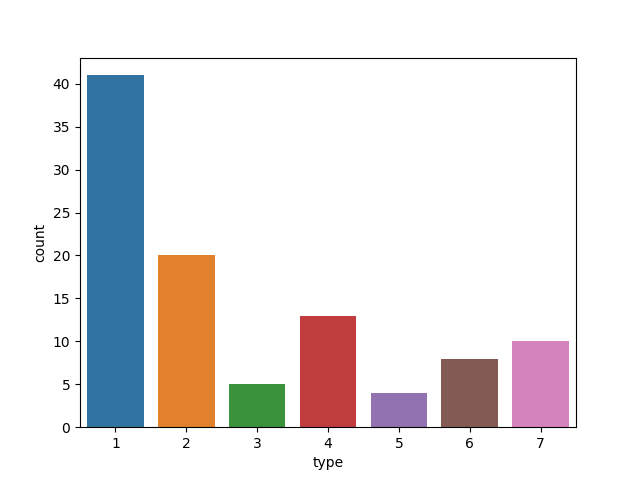

<AxesSubplot:xlabel='type', ylabel='count'>

In [5]:
# Show observation frequencies in classes.
sns.countplot(df['type'],label="Count")

<IPython.core.display.Javascript object>


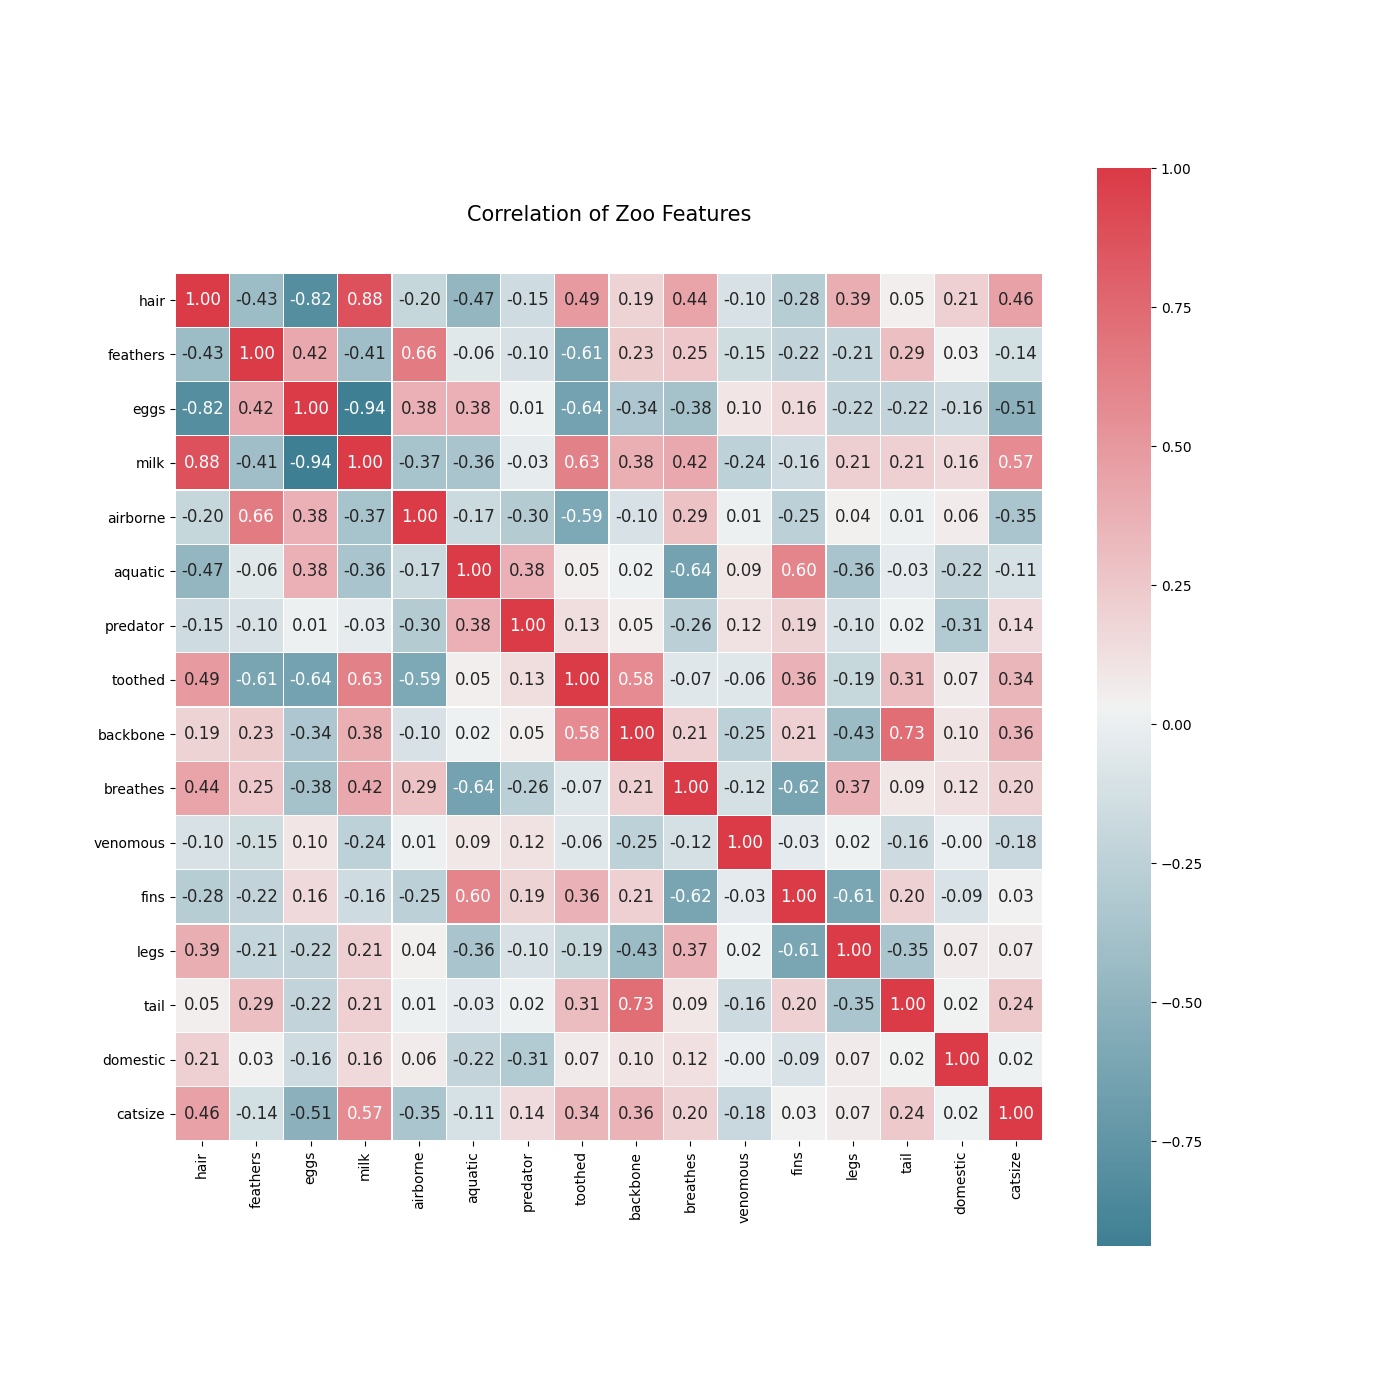

Text(0.5, 1.05, 'Correlation of Zoo Features')

In [6]:
# Show correlations. E.g.: hair - milk is high = mammals have hair and milk
corr = df.iloc[:,1:-1].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of Zoo Features', y=1.05, size=15) 

## 4. Dimensionality Reduction

### 4.1 Principal Component Analysis (PCA)

In [7]:
# Extract data matrix of size (n_samples, n_features) (but no animal name and type, so 16 features).
Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)
print(Y_uncentered.shape)
print(Y_uncentered)

(101, 16)
[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]


In [8]:
# Data centering (subtract mean of each columns/features from each entry in that column)
Y = data_centering(Y_uncentered=Y_uncentered)

In [9]:
# Do PCA on centered data and embed data into 2 dimensions.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Y)

In [10]:
print(pca.explained_variance_ratio_)

[0.62561548 0.14496905]


In [11]:
df_pca = pd.DataFrame({'pc1': X_pca[:, 0], 'pc2': X_pca[:, 1], 
                       'animal name': df['animal name'], 'type': df['type']})
print(df_pca.shape)
df_pca.head(20)

(101, 4)


,pc1,pc2,animal name,type
0,1.351029,-1.058533,aardvark,1
1,1.306634,-1.208344,antelope,1
2,-3.131655,0.252200,bass,4
3,1.351029,-1.058533,bear,1
4,1.277296,-1.225750,boar,1
5,1.306634,-1.208344,buffalo,1
6,1.321069,-1.257643,calf,1
7,-3.087882,0.220307,carp,4
8,-3.131655,0.252200,catfish,4
9,1.373629,-0.771044,cavy,1


<IPython.core.display.Javascript object>


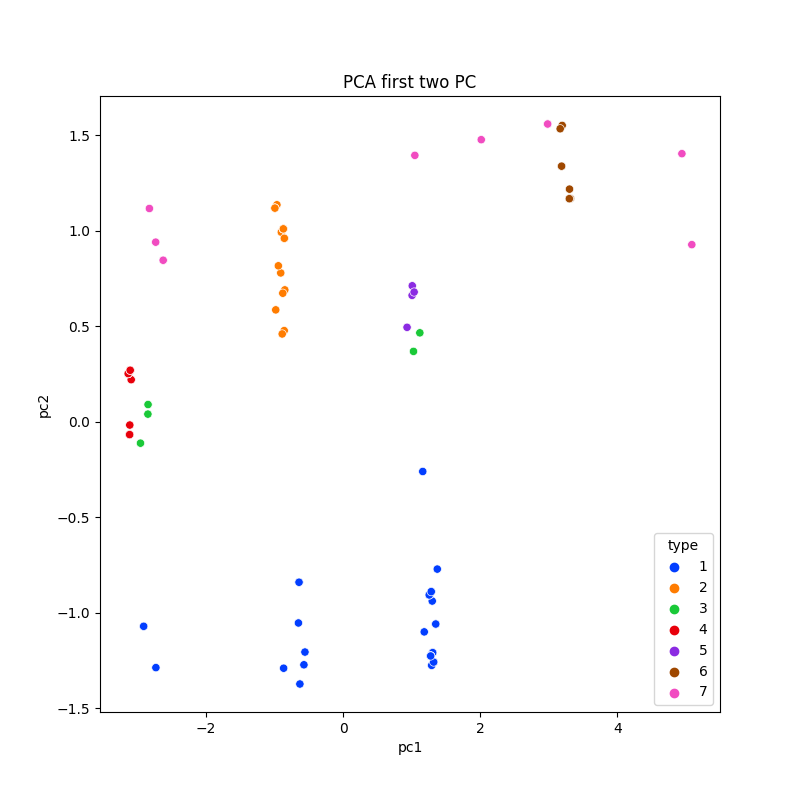

Text(0.5, 1.0, 'PCA first two PC')

In [12]:
# Generate figure.
fig= plt.figure(figsize=(8,8))

ax = sns.scatterplot(data=df_pca, x="pc1", y="pc2", hue="type", palette="bright")

ax.set_title("PCA first two PC")

### 2.2 Multi-Dimensional Scaling (MDS)

In [13]:
def squared_distance_marix_from_data(Y):
    """ Derive the pairwise distance matrix from the data matrix.
    
    Parameters
    ----------
    Y : numpy.ndarray
        The centered data matrix of shape (N, D) where N is the number of points and D is 
        the number of features/dimensions.
        
    Returns
    -------
    D : numpy.ndarray
        A symmetric matrix of the squared, pairwise Euclidean distances between feature vectors/points 
        in the data matrix. D has shape (N, N) where N is the number of observations/points in the data matrix.
        The data matrix from which D is derived is assumed to have been centered. All diagonals are 0 due to 
        the isolation property of the Euclidean distance.
    """
    D = euclidean_distances(Y)
    D = np.power(D, 2)
    
    assert is_symmetric(A=D), "The distance matrix is D non-symmetric."
    
    return D

In [14]:
def double_centering(D):
    """ Double centering trick to derive a similarity matrix from a pairwise distance matrix for 
    inputting to MDS.
    
    Parameters
    ----------
    D : numpy.ndarray
        A symmetric matrix of the squared, pairwise Euclidean distances between feature vectors/points 
        in the data matrix. D has shape (N, N) where N is the number of observations/points in the data matrix.
        The data matrix from which D is derived is assumed to have been centered. All diagonals are 0 due to 
        the isolation property of the Euclidean distance.
        
    Returns
    -------
    S : numpy.ndarray
        Gram matrix or pairwise similarity matrix (symmetric, real). The input to the MDS algorithm.
    """
    # Derive the Gram matrix of the data matrix from the distance matrix D. Use Numpy broadcasting to: 
    # (1) subtract from each entry of D the mean of the corresponding row
    # (2) subtract the mean of the corresponding column
    # (3) add back the mean of all entries
    S = -0.5 * (D - D.mean(axis=1).reshape(D.shape[0],1) - D.mean(axis=0).reshape(1,D.shape[0]) + D.mean())
    
    return S

In [15]:
def mds_from_distance_matrix(D):
    """ Multidimensional scaling (MDS) algorithm (classical MDS) with the pairwise distance matrix of the
    data matrix as input.
    
    Parameters
    ----------
    D : numpy.ndarray
        A symmetric matrix of the squared, pairwise Euclidean distances between feature vectors/points 
        in the data matrix. D has shape (N, N) where N is the number of observations/points in the data matrix.
        The data matrix from which D is derived is assumed to have been centered. All diagonals are 0 due to 
        the isolation property of the Euclidean distance.
        
    Returns
    -------
    X : numpy.ndarray
        Embedding of the data matrix from which the pairwise distance matrix D was derived.
        The shape of X is (J, N) where J is the dimension of the embedding.
        MDS is based on the eigendecomposition of the Gram matrix S (symmetric, real = real 
        eigenvalues and eigenvectors). Due to numerical stability issues, some eigenvalues close 
        to zero might end up being tiny negative numbers. As a result, X is the J dimensional representation/
        embedding of the data matrix where J corresponds to the number of strictily positive
        eigenvalues (J is lower than or equal to N).
    """
    # Get the Gram matrix.
    S = double_centering(D=D)
    
    # Eigendecomposition of S. Use the numpy.linalg.eigh to return the eigenvalues and 
    # eigenvectors of a complex Hermitian (conjugate symmetric) or a real symmetric matrix. 
    # Eigenvalues are in a 1-D matrix, eigenvectors are in a 2-D matrix of which each column is 
    # eigenvector at column index idx that corresponds to the eigenvalue at index idx among the 
    # eigenvalues.
    eigenvalues, eigenvectors = np.linalg.eigh(S)

    # Make sure that the eigenvalues and the eigenvectors are sorted in descending order based on the
    # eigenvalues.
    idx_descending   = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx_descending]
    eigenvectors = eigenvectors[:,idx_descending]
    
    # Only use the J positive eigenvalues and their corresponding eigenvectors to embed the data.                  
    idx_positive, = np.where(eigenvalues > 0)
    
    # Eigendecomposition with only the positive eigenvalues and their correspoinding eigenvectors.
    L  = np.diag(np.sqrt(eigenvalues[idx_positive]))
    U  = eigenvectors[:,idx_positive]
    
    # J dimensional embedding of the data matrix. Shape is (J, N). The best dimensions are at lower row indices. 
    X  = np.matmul(U, L)
    
    return X, eigenvalues

In [16]:
# Extract data matrix of size (n_samples, n_features) (but no animal name and type, so 16 features).
Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)
print(Y_uncentered.shape)
print(Y_uncentered)

(101, 16)
[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]


In [17]:
Y = data_centering(Y_uncentered=Y_uncentered)

In [18]:
D = squared_distance_marix_from_data(Y=Y)

In [19]:
X_mds, eigenvalues = mds_from_distance_matrix(D=D)

In [20]:
df_mds = pd.DataFrame({'dim1': X_mds[:, 0], 'dim2': X_mds[:, 1], 
                       'animal name': df['animal name'], 'type': df['type']})
print(df_mds.shape)
df_mds.head(90)

(101, 4)


,dim1,dim2,animal name,type
0,-1.351029,-1.058533,aardvark,1
1,-1.306634,-1.208344,antelope,1
2,3.131655,0.252200,bass,4
3,-1.351029,-1.058533,bear,1
4,-1.277296,-1.225750,boar,1
...,...,...,...,...
85,-2.014445,1.476383,starfish,7
86,3.108244,-0.017053,stingray,4
87,0.942773,0.816241,swan,2
88,-3.185266,1.337733,termite,6


<IPython.core.display.Javascript object>


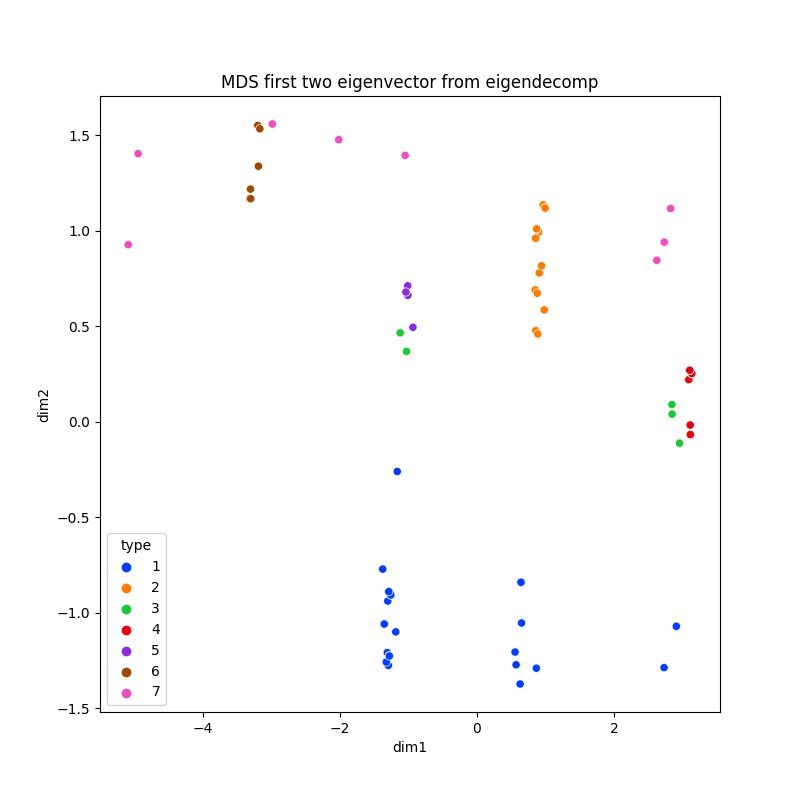

Text(0.5, 1.0, 'MDS first two eigenvector from eigendecomp')

In [21]:
# Generate figure.
fig = plt.figure(figsize=(8,8))

ax = sns.scatterplot(data=df_mds, x="dim1", y="dim2", hue="type", palette="bright")

ax.set_title("MDS first two eigenvector from eigendecomp")

## 3. Isomap

In [22]:
def neighbourhood_graph_from_squared_distance_matrix(D, k):
    """ Derives the shortest path graph of a data matrix Y from its squared pairwise distance matrix D while
    relying on the k-rule neighbourhood graph.
    
    Parameters
    ----------
    D : numpy.ndarray
        A symmetric matrix of the squared, pairwise Euclidean distances between feature vectors/points 
        in the data matrix. D has shape (N, N) where N is the number of observations/points in the data matrix.
        The data matrix from which D is derived is assumed to have been centered. All diagonals are 0 due to 
        the isolation property of the Euclidean distance.
    
    k : int
        The integer of the k-rule that controls how many neighbours a vertex stays connected to in the 
        k-rule neighbourhood graph.
        
    Returns
    -------
    G : numpy.ndarray
        Shortest path graph of the data matrix where the shortest paths are functions of k and 
        the distance matrix D. The shape of G is (N,N). All diagonals are 0 due to the isolation property
        of the Euclidean distance. 
    """
    # Create a sequence from 0 to k+1. Used in deriving the k-rule neighbourhood graph.
    # k + 1 since all diagonals are zero in the distance matrix (i.e.: all point is at 0 distance from itself)
    # so we need to find this zero distance (always diagonal) and the k other lowest distances.
    k_seq = [k for k in range(k+1)]

    # Iterate over all of the rows of the distance matrix D.
    for idx, row in enumerate(D):
        # Partition the rows into the lowest k+1 and the rest of the elements (since using k_seq, the lowest
        # elements are already sorted, see more in documnetation)
        # idx holds the indices of the k+1 lowest elements that include the point itself (idx) and the rest of
        # the k lowest elements.
        idx = np.argpartition(row, k_seq)
        
        # k-rule neighbourhood graph. Vector of the same size as the row of D with True for every point that
        # is not in the k nearest neighbour in the graph.
        # Note that if two points are at the same distance from the point at idx, both of them are kept 
        # (so actually in this case the point will have the k nearest neighbour with some other points 
        # at the same distances)
        k_rule_graph = np.max(row[idx[:k+1]]) < row
        
        # Mask the distances of D with the k_rule_graph Boolean mask. Every distance between points that are
        # not k-nearest neighbours is zeroed out. Now, diagonals and some other entries are also zero. 
        row[k_rule_graph] = 0

    # Create the shortest path graph. All diagonal are 0. Use the Floyd-Warshall algorithm, i.e.: FW.
    G = graph_shortest_path(D, method="FW")
    
    return G

In [23]:
def isomap(D, k=None):
    """ Derives the shortest path graph of a data matrix Y from its squared pairwise distance matrix D while
    relying on the k-rule neighbourhood graph.
    
    Parameters
    ----------
    D : numpy.ndarray
        Distance mat
    
    k : int
        The integer of the k-rule that controls how many neighbours a vertex stays connected to in the 
        k-rule neighbourhood graph.
        
    Returns
    -------
    X_isomap : numpy.ndarray
        Data matrix embedded via isomap of shape (N, J) where J is the number of positive eigenvalues
        of the spectral decomposition of the shortest path matrix G.
    
    eigenvaues_isomap : numpy.ndarray
        The eigenvalues (in descending order) of the shortest path graph distance matrix.
    """
    # Assert that k is valid.
    assert k is not None and isinstance(k, int), "k needs to be an integer"
    
    # Derive the shortest path graph distance matrix G from the squared pairwise distance matrix D using 
    # k for intermediate step of deriving the k-rule neighbourhodd graph.
    G = neighbourhood_graph_from_squared_distance_matrix(D=D, k=k)
    
    # Use the MDS on the shortest path graph distance matrix G (G is symmetric).  
    X_isomap, eigenvaues_isomap = mds_from_distance_matrix(D=G)
    
    return X_isomap, eigenvaues_isomap, G

In [24]:
# Extract data matrix of size (n_samples, n_features) (but no animal name and type, so 16 features).
Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)
print(Y_uncentered.shape)
print(Y_uncentered)

(101, 16)
[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 0. 0.]]


In [25]:
Y = data_centering(Y_uncentered=Y_uncentered)

In [26]:
# Derive the squared pairwise distance matrix D from the centered data matrix Y.
D = squared_distance_marix_from_data(Y=Y)

In [27]:
k = 50
X_isomap, eigenvaues_isomap, G = isomap(D=D, k=k)

In [28]:
df_isomap = pd.DataFrame({'dim1': X_isomap[:, 0], 'dim2': X_isomap[:, 1], 
                          'animal name': df['animal name'], 'type': df['type']})
print(df_isomap.shape)
df_isomap.head(90)

(101, 4)


,dim1,dim2,animal name,type
0,1.315674,-1.051204,aardvark,1
1,1.196540,-1.145252,antelope,1
2,-2.386365,-0.396596,bass,4
3,1.313717,-1.051224,bear,1
4,1.167069,-1.166017,boar,1
...,...,...,...,...
85,1.219362,1.536261,starfish,7
86,-2.262380,-0.496015,stingray,4
87,-0.875168,0.963841,swan,2
88,1.677850,1.736601,termite,6


<IPython.core.display.Javascript object>


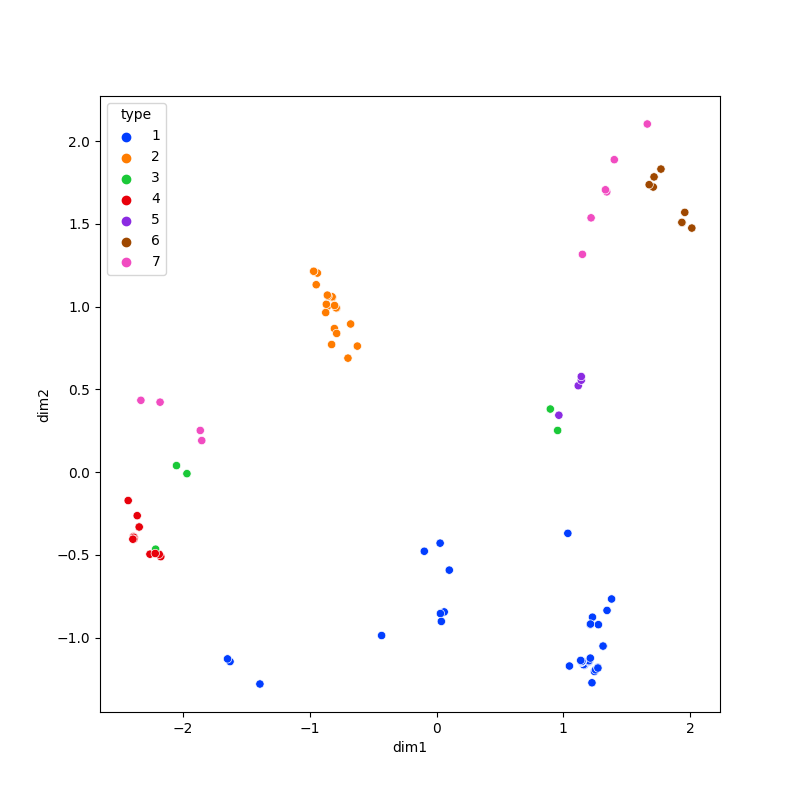

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

In [29]:
# Generate figure.
fig = plt.figure(figsize=(8,8))

sns.scatterplot(data=df_isomap, x="dim1", y="dim2", hue="type", palette="bright")

In [30]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


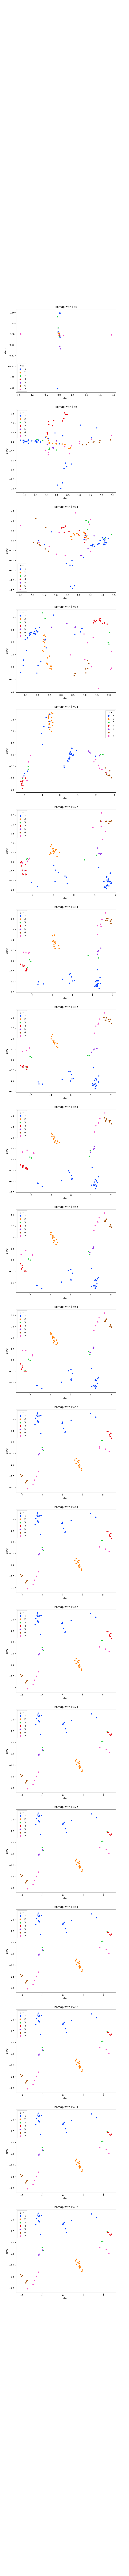

In [31]:
# Isomap exploration.
ks = [k for k in range(1,101,5)]

obj_func_vals = []

fig, axs = plt.subplots(nrows=len(ks), ncols=1, figsize=(8,8*len(ks)))

for k, ax in zip(ks, axs):
    
    Y_uncentered = df.iloc[:,1:-1].to_numpy().astype(np.float64)
    
    # Center the data matrix.
    Y = data_centering(Y_uncentered=Y_uncentered)
    
    # Derive the squared pairwise distance matrix D from the centered data matrix Y.
    D = squared_distance_marix_from_data(Y=Y)
    
    X_isomap, eigenvaues_isomap, G = isomap(D=D, k=k)
    
    # Get the Gram matrix (also computed in mds within isomap, just also needed here)
    S = double_centering(D=G)
    
    S_reconstructed = np.matmul(X_isomap, X_isomap.transpose())
    
    error_mds = np.sum(np.power(S - S_reconstructed, 2))
    
    df_isomap = pd.DataFrame({'dim1': X_isomap[:, 0], 'dim2': X_isomap[:, 1], 
                          'animal name': df['animal name'], 'type': df['type']})
    
    sns.scatterplot(data=df_isomap, x="dim1", y="dim2", hue="type", palette="bright", ax=ax)
    ax.set_title(f"Isomap with k={k}")
    
plt.show()

In [32]:
# Distance -> shortest path dsitance graph check

k = 2
k_seq = [k for k in range(k+1)]

A = np.array([[0,1,4,2,6], 
              [1,0,3,2,11], 
              [4,3,0,1,3],
              [2,2,1,0,5],
              [6,11,3,5,0]])
print(A)
print(is_symmetric(A))

print(k_seq)
idx = np.argpartition(A, k_seq)
print(idx)

B = np.zeros(A.shape)

for idx, row in enumerate(A):
    idx = np.argpartition(row, k_seq)
    #print(idx)
    #print(row[idx[:k+1]])
    print(np.max(row[idx[:k+1]]) < row)
    
    row[np.max(row[idx[:k+1]]) < row] = 0
    
print("Eliminated")
print(A)

G = graph_shortest_path(A, method="FW")
print("Graph")
print(G)

[[ 0  1  4  2  6]
 [ 1  0  3  2 11]
 [ 4  3  0  1  3]
 [ 2  2  1  0  5]
 [ 6 11  3  5  0]]
True
[0, 1, 2]
[[0 1 3 2 4]
 [1 0 3 2 4]
 [2 3 1 0 4]
 [3 2 1 0 4]
 [4 2 3 1 0]]
[False False  True False  True]
[False False  True False  True]
[ True False False False False]
[False False False False  True]
[ True  True False False False]
Eliminated
[[0 1 0 2 0]
 [1 0 0 2 0]
 [0 3 0 1 3]
 [2 2 1 0 0]
 [0 0 3 5 0]]
Graph
[[0. 1. 3. 2. 6.]
 [1. 0. 3. 2. 6.]
 [3. 3. 0. 1. 3.]
 [2. 2. 1. 0. 4.]
 [6. 6. 3. 4. 0.]]


In [33]:
k = 2
k_seq = [k for k in range(k+1)]

A = np.array([[0,1,4,2], 
              [1,0,3,2], 
              [4,3,0,1],
              [2,2,1,0]])
print(A)
is_symmetric(A)

print(k_seq)
idx = np.argpartition(A, k_seq)
print(idx)

B = np.zeros(A.shape)

for idx, row in enumerate(A):
    idx = np.argpartition(row, k_seq)
    #print(idx)
    #print(row[idx[:k+1]])
    print(np.max(row[idx[:k+1]]) < row)
    
    row[np.max(row[idx[:k+1]]) < row] = 0
    
print("Eliminated")
print(A)

G = graph_shortest_path(A, method="FW")
print("Graph")
print(G)

[[0 1 4 2]
 [1 0 3 2]
 [4 3 0 1]
 [2 2 1 0]]
[0, 1, 2]
[[0 1 3 2]
 [1 0 3 2]
 [2 3 1 0]
 [3 2 1 0]]
[False False  True False]
[False False  True False]
[ True False False False]
[False False False False]
Eliminated
[[0 1 0 2]
 [1 0 0 2]
 [0 3 0 1]
 [2 2 1 0]]
Graph
[[0. 1. 3. 2.]
 [1. 0. 3. 2.]
 [3. 3. 0. 1.]
 [2. 2. 1. 0.]]


In [34]:
B = np.array([[1,2],[3,4]])

C = B.copy()

C[1][1] = -2

print(B)
print(C)

C[1][0] = 2331

print(B)
print(C)

[[1 2]
 [3 4]]
[[ 1  2]
 [ 3 -2]]
[[1 2]
 [3 4]]
[[   1    2]
 [2331   -2]]
